[*********************100%***********************]  2 of 2 completed


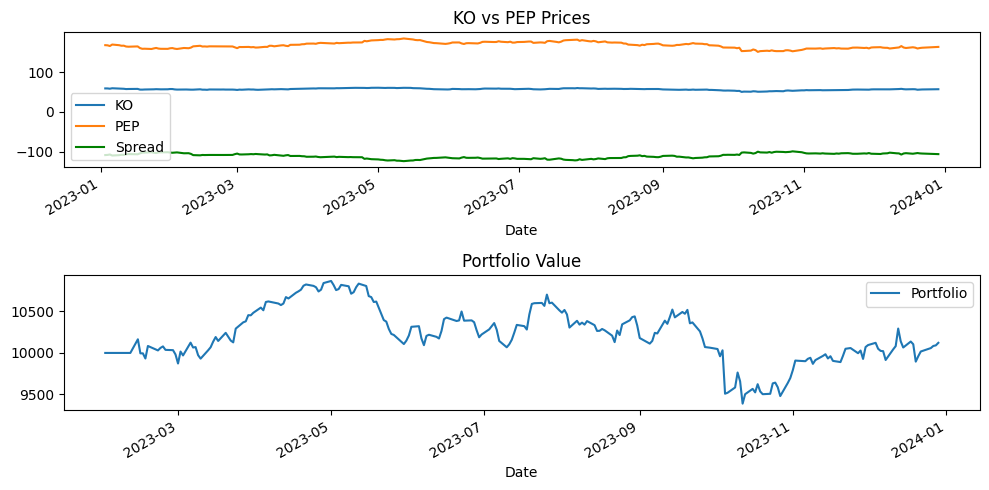

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pepsi = "PEP"
coke = "KO"

data = yf.download([coke, pepsi], start="2023-01-01", end="2024-01-01")["Close"]
spread = data[coke] - data[pepsi]

spread_mew = spread.rolling(window=20).mean()
spread_sigma = spread.rolling(window=20).std()
data["Mew"] = spread_mew
data["Sigma"] = spread_sigma
data["Spread"] = spread


cash = 10000
a_stocks = 0
b_stocks = 0

for date, row in data.iterrows():
    if pd.isna(row["Mew"]) or pd.isna(row["Spread"]):
        continue

    mew = row["Mew"]
    sigma = row["Sigma"]
    spread = row["Spread"]
    a_price = row[coke]
    b_price = row[pepsi]

    if spread > (mew + 2 * sigma):
        cash += a_stocks*a_price
        a_stocks = 0
        b_stocks += cash/b_price
        cash = 0
    if spread < (mew - 2 * sigma):
        cash += b_stocks*b_price
        b_stocks = 0
        a_stocks += cash/a_price
        cash = 0

    value = a_stocks*a_price + b_stocks*b_price + cash
    data.loc[date, "Portfolio"] = value

portfolio = data["Portfolio"]
spread = data["Spread"]


plt.figure(figsize=(10, 5))

# Plot KO, PEP, and Spread
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
data[coke].plot(title="KO vs PEP Prices", ax=plt.gca())  # Plotting KO
data[pepsi].plot(ax=plt.gca(), label='PEP')  # Plotting PEP
spread.plot(ax=plt.gca(), label='Spread', color='green')  # Plotting Spread
plt.legend([coke, pepsi, 'Spread'])

# Plot portfolio value
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
portfolio.plot(title="Portfolio Value", ax=plt.gca())
plt.legend(['Portfolio'])

# Show the plots
plt.tight_layout()
plt.show()